In [20]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import pandas as pd
import numpy as np
import time


In [22]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn import metrics

def load_csv(file, describe=False):
    df = pd.read_csv(file, na_values='NA')
    df = df.drop(['id', 'Unnamed: 0'], axis=1) # Dropping the ID column
    
    # Display basic information
    df.info()
    if describe:
        print(df.describe(include='all'))

    X = df.drop(['loss'], axis=1) # Features
    y = (df.loc[:,'loss'] > 0) # Labels
    if describe:
        print(X.shape, y.shape)
    
    return df, X, y


def split_data(kf, X, y, describe=False): 
    splits = list(kf.split(X))
    train_index, valid_index = splits[0] # Take the first split only    
    if describe:
        print("Training set: ", train_index)
        print("Validation set: ", valid_index)
    
    X_train, X_valid = X.iloc[train_index, :], X.iloc[valid_index, :]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    return X_train, y_train, X_valid, y_valid
def train_model(clf, X_train, y_train):
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    fit_time = end - start
    print('Time elapsed (Training): %.4f s' % fit_time)
    print(clf)

    return fit_time


def evaluate (clf, X_train, y_train, X_valid, y_valid, plot=True):
    # Plotting ROCAUC and PRAUC
    f, (plt1, plt2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))        
    plt1.set_title('ROC Curve')
    plt1.set_xlabel('FPR')
    plt1.set_ylabel('TPR')
    plt2.set_title('PR Curve')
    plt2.set_xlabel('Precision')
    plt2.set_ylabel('Recall')

    start = time.time()

    # Training set    
    y_train_predicted = clf.predict_proba(X_train)
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_predicted[:,1])
    precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_train_predicted[:,1])
    plt1.scatter(fpr, tpr, color='b')    
    plt2.scatter(precision, recall,color='b')
    print('Accuracy (Training): %f' % clf.score(X_train, y_train))
    print('ROCAUC Score (Training): %f' % metrics.roc_auc_score(y_train, y_train_predicted[:,1]))
    

# Validation set
    y_valid_predicted = clf.predict_proba(X_valid)    
    fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_valid_predicted[:,1])
    precision, recall, thresholds = metrics.precision_recall_curve(y_valid, y_valid_predicted[:,1])
    plt1.scatter(fpr, tpr, color='r')
    plt2.scatter(precision, recall,color='r')
    acc_score = clf.score(X_valid, y_valid)
    print('Accuracy (Validation): %f' % acc_score)
    rocauc_score = metrics.roc_auc_score(y_valid, y_valid_predicted[:,1])
    print('ROCAUC Score (Validation): %f' % rocauc_score)
   
    

    end = time.time()
    eval_time = end - start
    print('Time elapsed (Evaluation): %.4f s' % eval_time)

    if plot:
        plt.show()
    plt.close()
    
    return acc_score, rocauc_score, eval_time

def plot_metrics (var_s, var_name, is_float, fit_times, eval_times, acc_scores, rocauc_scores):
    import matplotlib.patches as mpatches
    patches = [mpatches.Patch(color='black', label='Fitting Time'), 
               mpatches.Patch(color='blue', label='Evaluation Time')]
    plt.xlabel(var_name)
    plt.ylabel('Model Fitting/Evaluation Time (s)')
    plt.legend(handles=patches)
    plt.scatter(var_s, fit_times, color='black')
    plt.scatter(var_s, eval_times, color='blue')
    plt.show()

    patches = [mpatches.Patch(color='blue', label='Accuracy'), 
               mpatches.Patch(color='green', label='ROCAUC'), 
               ]
    plt.xlabel(var_name)
    plt.ylabel('Metrics')
    plt.legend(handles=patches)
    plt.scatter(var_s, acc_scores, color='blue')
    plt.scatter(var_s, rocauc_scores, color='green')
    
    plt.show()

    results = pd.DataFrame({'0_' + var_name: var_s, '1_Accuracy': acc_scores, '2_ROCAUC': rocauc_scores,  '4_fit_time': fit_times, '5_eval_time': eval_times})
    print(results)
    print('\n')
    print(results.describe())
    print('\n')
    if is_float:
        print('Best accuracy score=%f, at %s=%f' % (max(acc_scores), var_name, var_s[acc_scores.index(max(acc_scores))]))
        print('Best ROCAUC score=%f, at %s=%f' % (max(rocauc_scores), var_name, var_s[rocauc_scores.index(max(rocauc_scores))]))
        
    else:
        print('Best accuracy score=%f, at %s=%d' % (max(acc_scores), var_name, var_s[acc_scores.index(max(acc_scores))]))
        print('Best ROCAUC score=%f, at %s=%d' % (max(rocauc_scores), var_name, var_s[rocauc_scores.index(max(rocauc_scores))]))
       


In [23]:
# Load the training data (imputed but not normalized) from the CSV file

df, X, y =load_csv('/content/drive/MyDrive/Colab Notebooks/train_v2_preprocessed.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 1789 entries, f1_x0_103 to loss
dtypes: float64(1736), int64(53)
memory usage: 1.4 GB


In [24]:
# Separate training and validation sets

from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
X_train, y_train, X_valid, y_valid =split_data(kf, X, y)

Time elapsed (Training): 5.2482 s
GaussianNB(priors=None, var_smoothing=1e-09)
Accuracy (Training): 0.848417
ROCAUC Score (Training): 0.562101
Accuracy (Validation): 0.858971
ROCAUC Score (Validation): 0.542484
Time elapsed (Evaluation): 6.9972 s


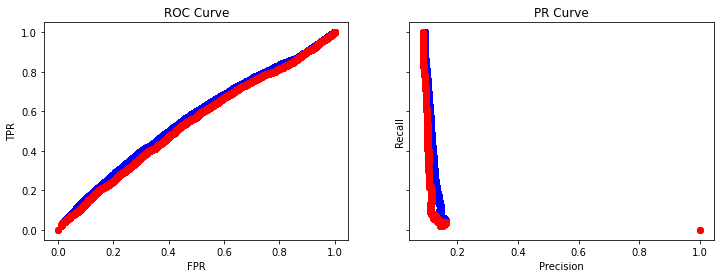

In [10]:
from sklearn.naive_bayes import GaussianNB
import time

clf =GaussianNB()
fit_time = train_model(clf, X_train, y_train)
acc_score, rocauc_score, eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)

In [11]:
# Load the training data (imputed and normalized) from the CSV file

df, X, y =load_csv('/content/drive/MyDrive/Colab Notebooks/train_v2_preprocessed_normalized.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 1789 entries, f3 to loss
dtypes: float64(1788), int64(1)
memory usage: 1.4 GB


Time elapsed (Training): 3.8441 s
GaussianNB(priors=None, var_smoothing=1e-09)
Accuracy (Training): 0.848417
ROCAUC Score (Training): 0.562101
Accuracy (Validation): 0.858971
ROCAUC Score (Validation): 0.542484
Time elapsed (Evaluation): 6.7120 s


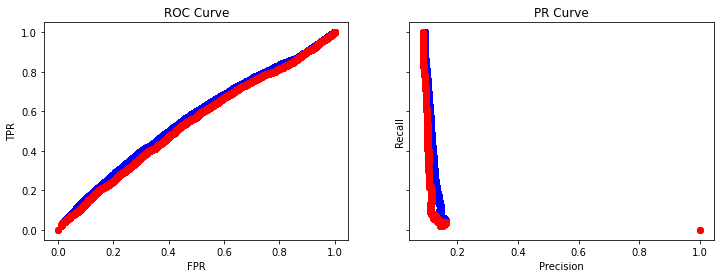

In [14]:
from sklearn.naive_bayes import GaussianNB
import time

clf =GaussianNB()
fit_time = train_model(clf, X_train, y_train)
acc_score, rocauc_score, eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)

Time elapsed (Training): 7.5759 s
BernoulliNB(alpha=1, binarize=0.0, class_prior=None, fit_prior=True)
Accuracy (Training): 0.485245
ROCAUC Score (Training): 0.632630
Accuracy (Validation): 0.485660
ROCAUC Score (Validation): 0.621440
Time elapsed (Evaluation): 19.6570 s


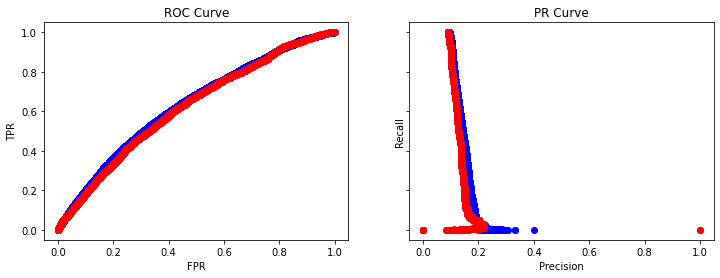

In [30]:
from sklearn.naive_bayes import BernoulliNB
import time

clf =BernoulliNB(alpha=1)
fit_time = train_model(clf, X_train, y_train)
acc_score, rocauc_score, eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)